In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
import seaborn as sns
import csv
import os
import logging
import math
import re

In [216]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [217]:
#https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv comme base
#detecte automatiquement le sep d'un fichier csv
def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

In [218]:
#lecture d'un fichier csv en essayant différents encodage.
def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

In [219]:
#chargement des datasets dans des listes
def load_datasets(prefixes, years, base_path='data/raw'):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            connector = '_' if year <= 2016 else '-'
            file_name = os.path.join(base_path, f'{prefix}{connector}{year}.csv')
            df, success, error = read_csv_file(file_name)
            if success:
                datasets.append({file_name: df})
            else:
                logging.error(error)
        dataframes.append(datasets)
    
    return dataframes

In [220]:
years = list(range(2005, 2023))
prefixes= ['vehicules']

dataframes = load_datasets(prefixes, years)

#log
for prefix, df_list in zip(prefixes, dataframes):
        logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-06-10 16:34:04,488 - INFO - vehicules: 18 datasets chargés.
2024-06-10 16:34:04,489 - INFO - Total datasets chargés: 18.


In [221]:
def extract_year(file_name):
    match = re.search(r'(\d{4})\.csv$', file_name)
    if match:
        return match.group(1)
    else:
        return None

In [222]:
#création d'une grille de boxplot
def create_boxplot_grid(column, datasets):

    if not any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        logging.info(f"La colonne {column} n'est pas numérique.")
        return

    n_datasets = len(datasets)
    n_cols = 5
    n_rows = math.ceil(n_datasets / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 2), squeeze=False)
    fig.suptitle(f'Boxplots for column: {column}', fontsize=16)
    
    for ax, dataset in zip(axes.flatten(), datasets):
        for file_name, df in dataset.items():
            if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
                ax.boxplot(df[column].dropna(), vert=True)
                ax.set_title(extract_year(file_name))
                ax.set_xlabel(column)
                ax.set_ylabel('Values')
    
    # Masquer les axes non utilisés
    for ax in axes.flatten()[n_datasets:]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [223]:
#création du bar plot pour visualiser la distribution des modalités.
def create_total_stacked_barplot(column, datasets, max_modalities=50):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                modality_count = df[column].value_counts()
                modality_counts[file_name] = modality_count
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Auncun bar plot généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = [extract_year(file_name) for file_name in modality_counts.keys()]
    
    for modality in all_modalities:
        for file_name in modality_counts.keys():
            count = modality_counts[file_name].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years).transpose()
    
    df_modalities.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')
    plt.title(f'{column}')
    plt.xlabel('Modalities')
    plt.ylabel('Count')
    plt.legend(title='Years', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [224]:
def create_lineplot_evolution(column, datasets, max_modalities=12):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                year = extract_year(file_name)
                modality_count = df[column].value_counts(normalize=True) * 100
                if year not in modality_counts:
                    modality_counts[year] = modality_count
                else:
                    modality_counts[year] = modality_counts[year].add(modality_count, fill_value=0)
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun graphique en ligne généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = sorted(modality_counts.keys())
    
    for modality in all_modalities:
        for year in years:
            count = modality_counts[year].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years)
    
    df_modalities.plot(kind='line', figsize=(15, 7), marker='o')
    plt.title(f'Evolution of Distribution for column: {column}')
    plt.xlabel('Years')
    plt.ylabel('Proportion (%)')
    plt.legend(title='Modalities', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [225]:
def analyze_column(column, datasets, total_rows):
    column_results = []
    
    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                col_type = df[column].dtype
                col_mode = df[column].mode()[0] if not df[column].mode().empty else "N/A"
                null_proportion_file = df[column].isnull().mean() *100
                null_proportion_total = df[column].isnull().sum() / total_rows
                column_results.append([
                    extract_year(file_name), 
                    col_type, 
                    col_mode, 
                    null_proportion_file, 
                    null_proportion_total
                ])
    
    if column_results:
        print(f"\nColonne: {column} / lignes: {total_rows}")
        print(tabulate(column_results, headers=[
            "Année", "Type", "Mode", 
            "Proportion valeurs nulles (fichier)", 
            "Proportion valeurs nulles (total)"
        ]))
        
        #if any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        create_boxplot_grid(column, datasets) 
        create_total_stacked_barplot(column, datasets)
        create_lineplot_evolution(column, datasets)


In [226]:
#on analyse toutes les colonnes à la suite
def analyze_all_columns(datasets):
    all_columns = set()
    for dataset in datasets:
        for file_name, df in dataset.items():
            logging.info(f'Chargement de {file_name}.')
            all_columns.update(df.columns)
    
    total_rows = sum(df.shape[0] for dataset in datasets for file_name, df in dataset.items())
    
    #traitement pour chaque colonne
    for column in all_columns:
        analyze_column(column, datasets, total_rows)
            

2024-06-10 16:34:04,616 - INFO - Chargement de data/raw\vehicules_2005.csv.
2024-06-10 16:34:04,617 - INFO - Chargement de data/raw\vehicules_2006.csv.
2024-06-10 16:34:04,617 - INFO - Chargement de data/raw\vehicules_2007.csv.
2024-06-10 16:34:04,619 - INFO - Chargement de data/raw\vehicules_2008.csv.
2024-06-10 16:34:04,619 - INFO - Chargement de data/raw\vehicules_2009.csv.
2024-06-10 16:34:04,621 - INFO - Chargement de data/raw\vehicules_2010.csv.
2024-06-10 16:34:04,621 - INFO - Chargement de data/raw\vehicules_2011.csv.
2024-06-10 16:34:04,623 - INFO - Chargement de data/raw\vehicules_2012.csv.
2024-06-10 16:34:04,624 - INFO - Chargement de data/raw\vehicules_2013.csv.
2024-06-10 16:34:04,625 - INFO - Chargement de data/raw\vehicules_2014.csv.
2024-06-10 16:34:04,626 - INFO - Chargement de data/raw\vehicules_2015.csv.
2024-06-10 16:34:04,626 - INFO - Chargement de data/raw\vehicules_2016.csv.
2024-06-10 16:34:04,627 - INFO - Chargement de data/raw\vehicules-2017.csv.
2024-06-10 1


Colonne: choc / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0379906                          2.38878e-05
   2010  float64       1                              0.0144382                          8.46026e-06
   2011  float64       1                              0.0368893                          2.09018e-05
   2012  float64       1                              0.0321319                          1.69205e-

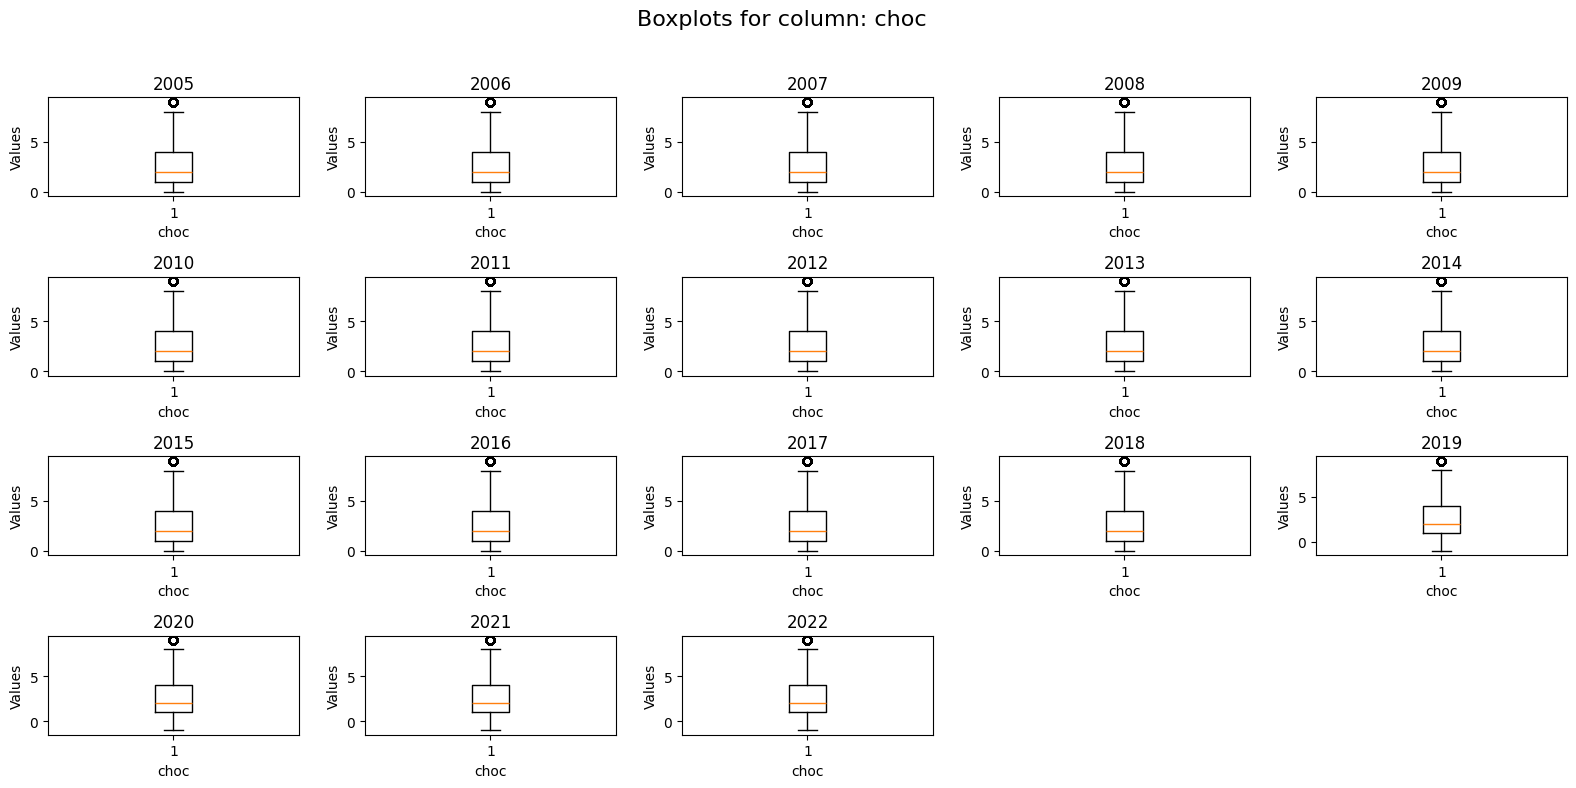

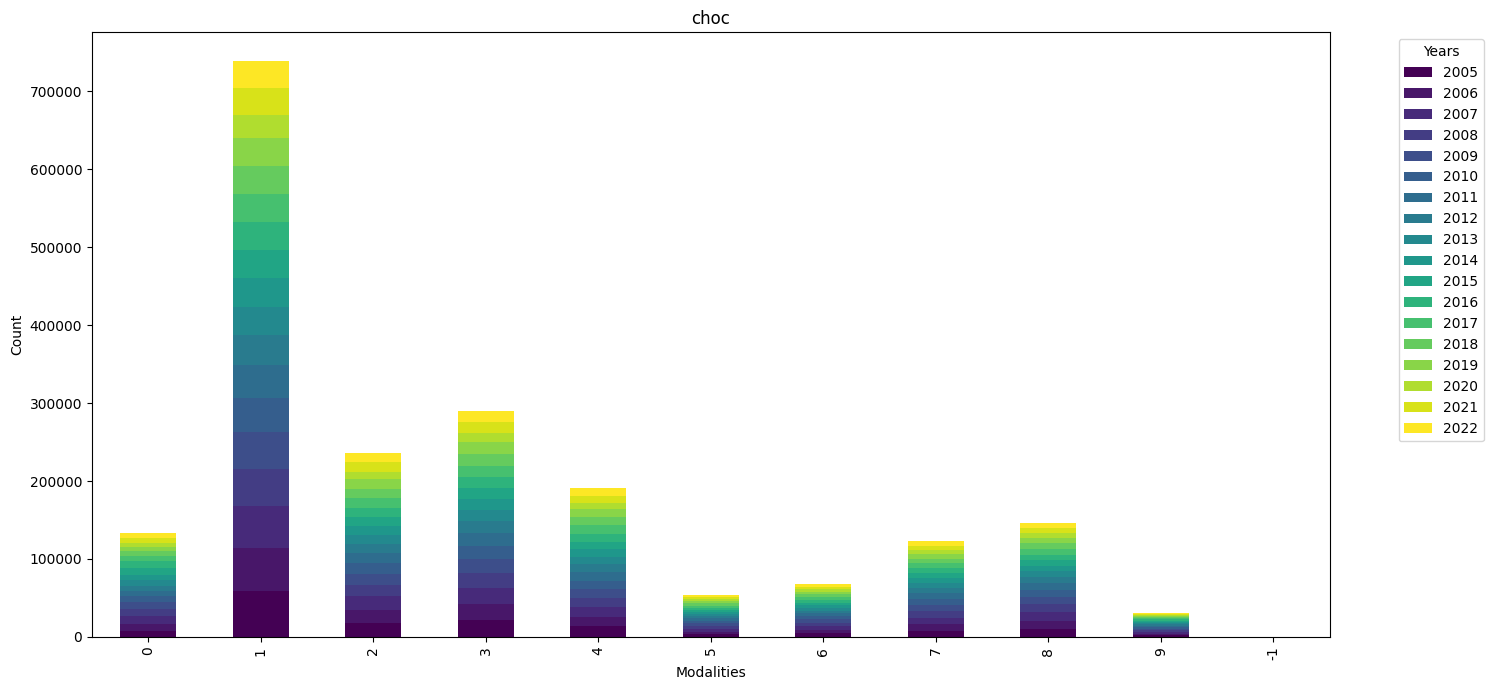

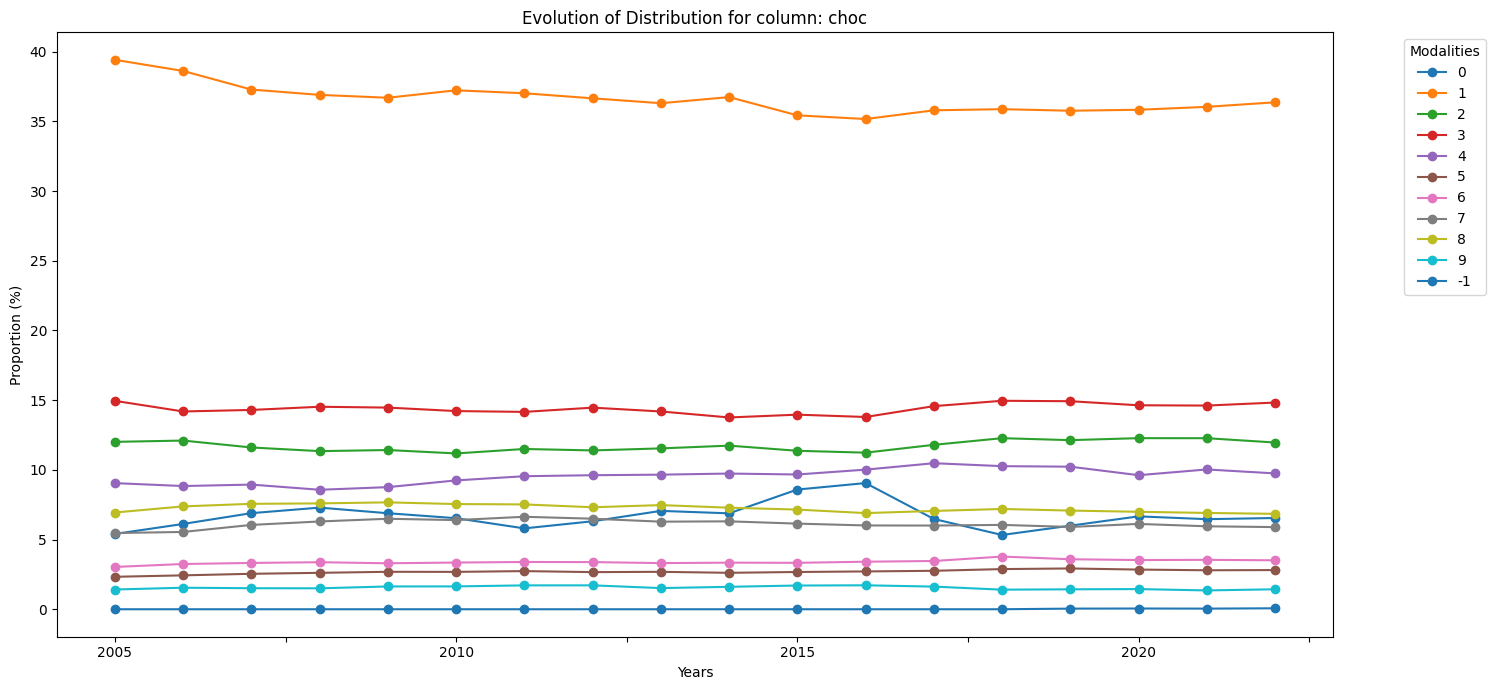

2024-06-10 16:34:08,097 - INFO - La colonne id_vehicule n'est pas numérique.
2024-06-10 16:34:08,311 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Auncun bar plot généré.



Colonne: id_vehicule / lignes: 2009395
  Année  Type    Mode           Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -----------  -------------------------------------  -----------------------------------
   2019  object  137 982 129                                      0                                    0
   2020  object  154 658 350                                      0                                    0
   2021  object  100 882                                          0                                    0
   2022  object  715 629                                          0                                    0


2024-06-10 16:34:08,538 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: obs / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.208157                           0.000130885
   2010  float64       0                              0.0721911                          4.23013e-05
   2011  float64       0                              0.10979                            6.22078e-05
   2012  float64       0                              0.0614285                          3.2348e-05

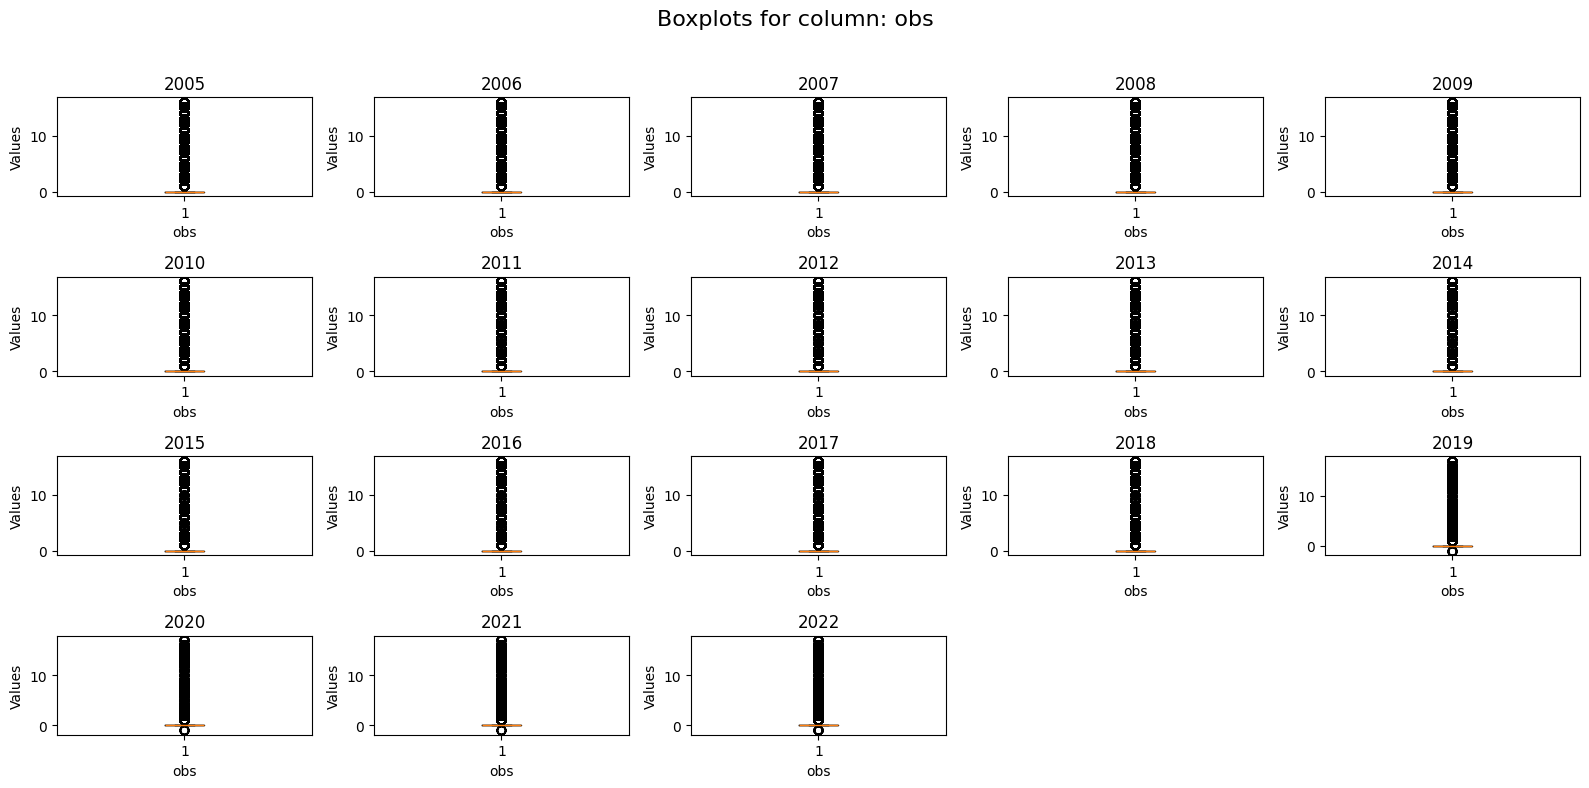

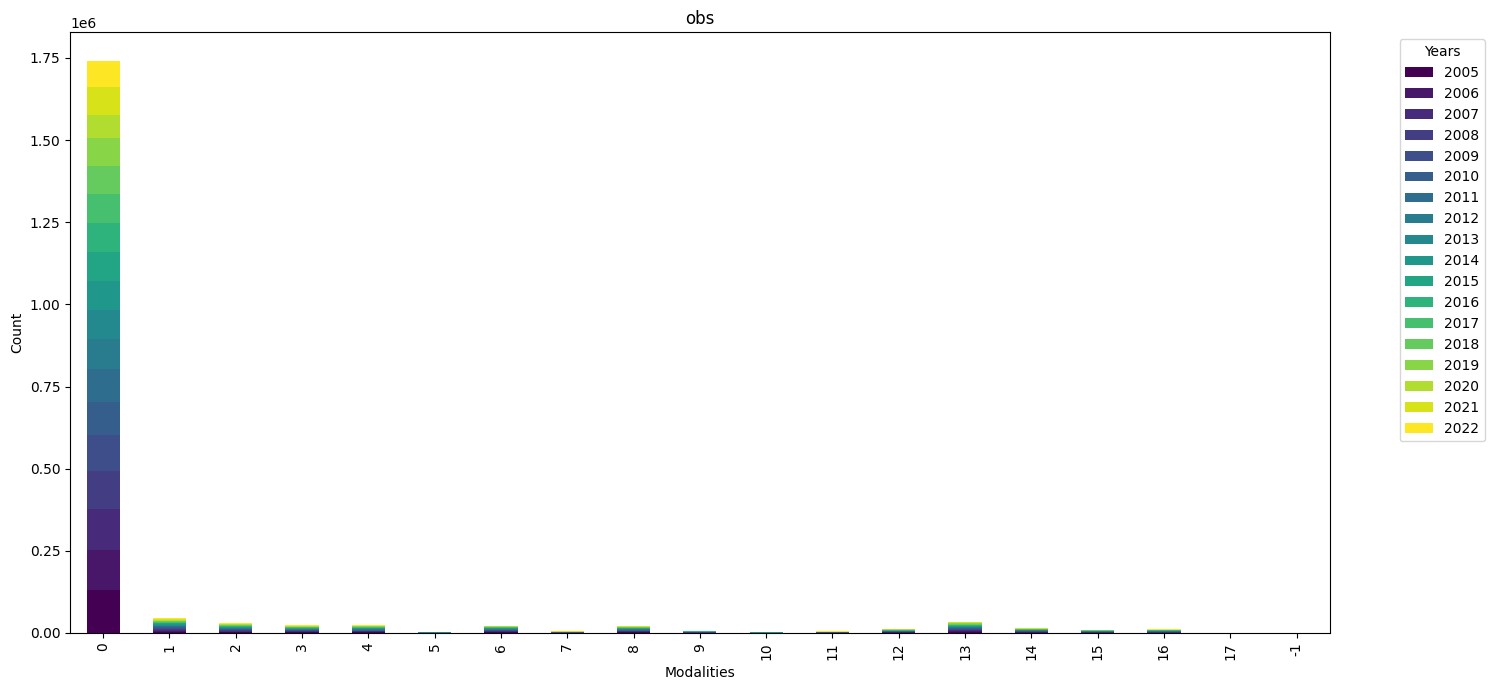

2024-06-10 16:34:11,214 - WARNING - Le nombre de modalités uniques dans la colonne obs excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: obsm / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0989339                          6.22078e-05
   2010  float64       2                              0.0433147                          2.53808e-05
   2011  float64       2                              0.0667522                          3.78223e-05
   2012  float64       2                              0.0916703                          4.82732e-

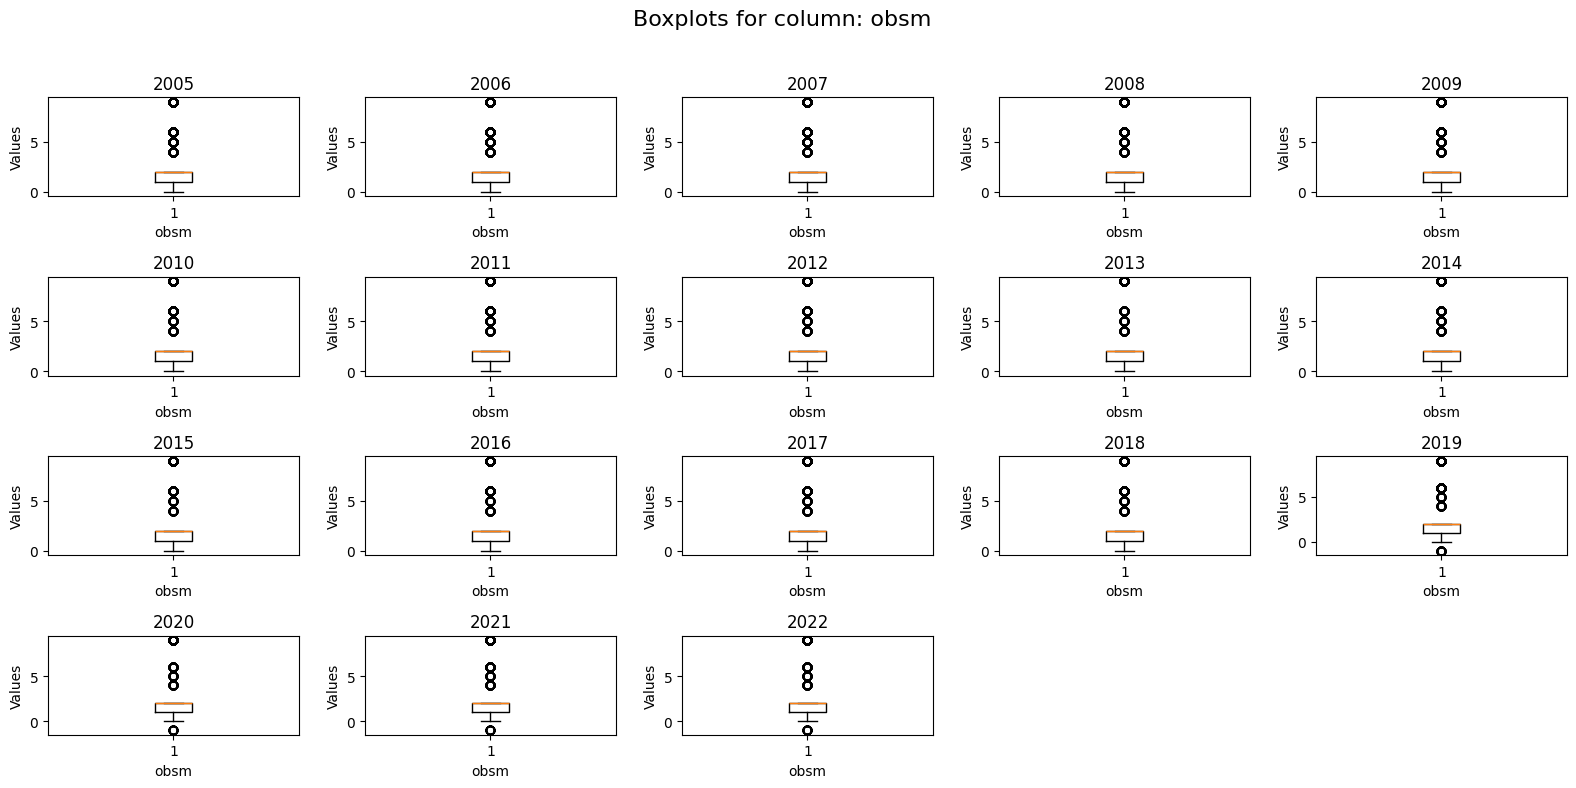

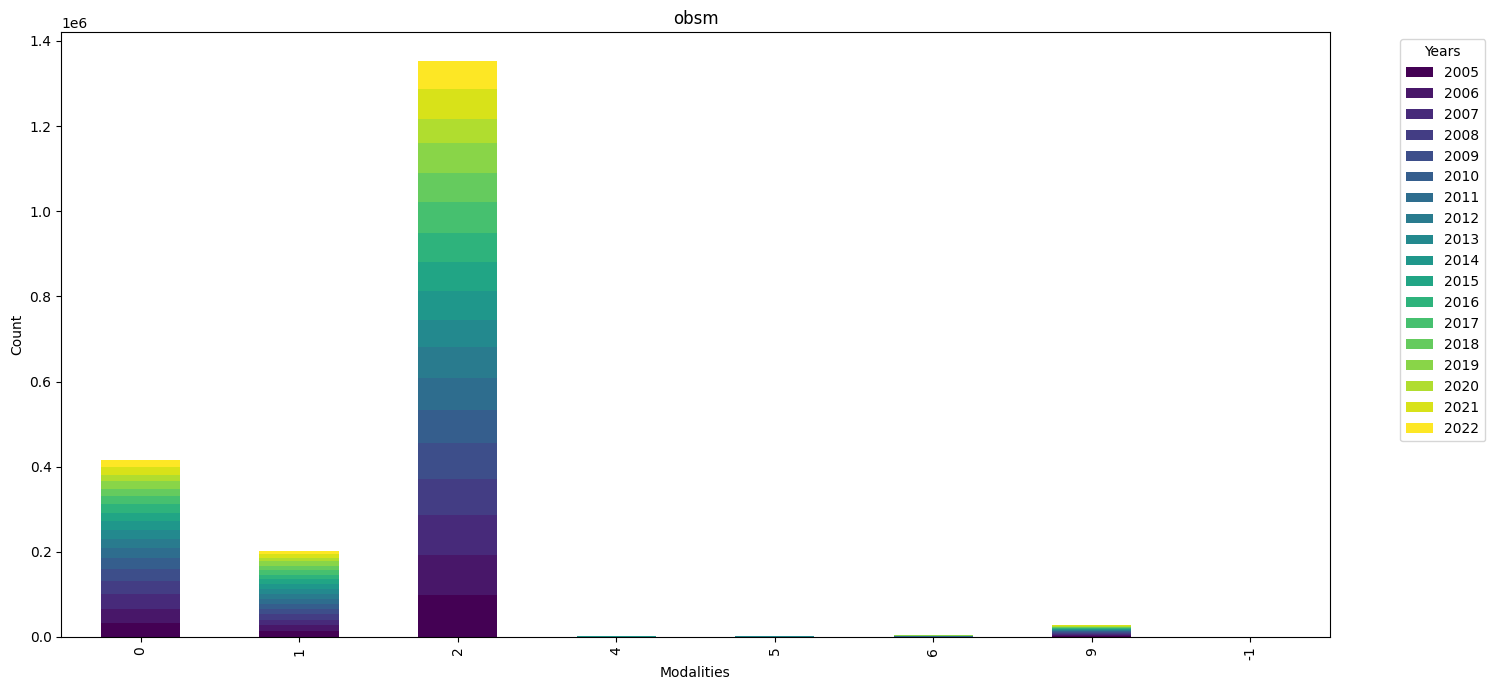

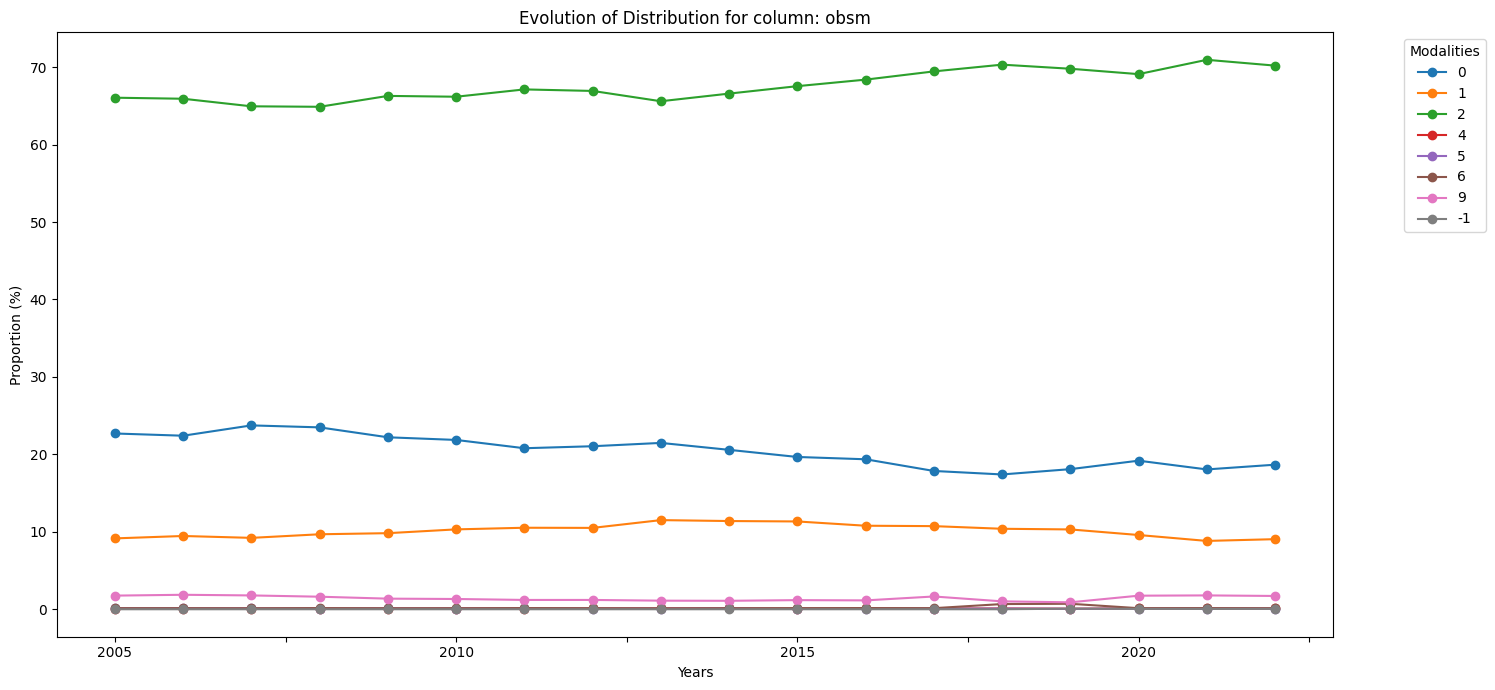


Colonne: manv / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                             0                                   0
   2006  int64         1                             0                                   0
   2007  int64         1                             0                                   0
   2008  int64         1                             0                                   0
   2009  float64       1                             0.0625262                           3.93153e-05
   2010  float64       1                             0.011041                            6.46961e-06
   2011  float64       1                             0.0447942                           2.53808e-05
   2012  float64       1                             0.0425275                           2.23948e-

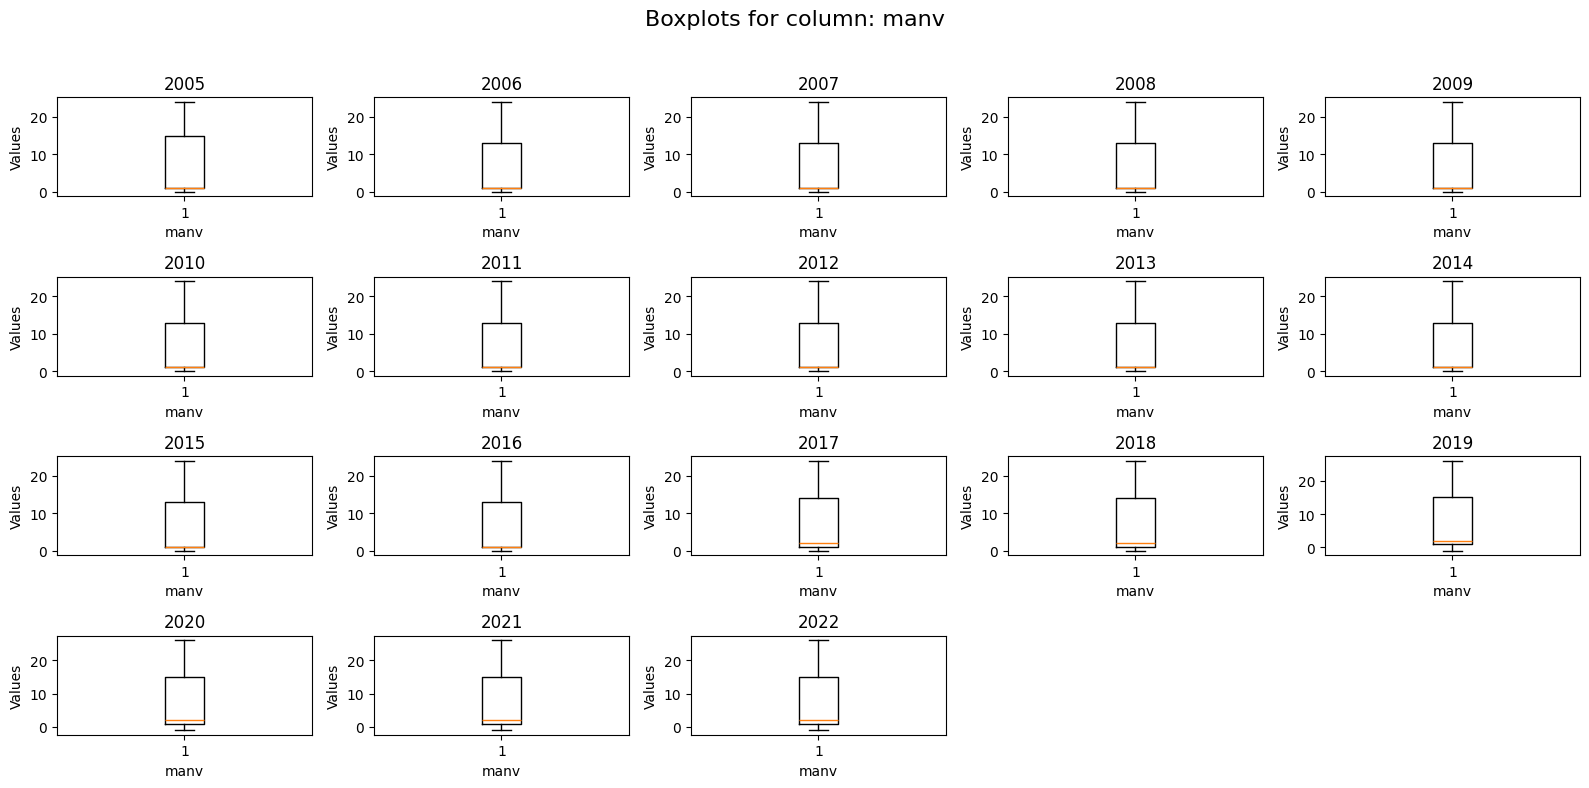

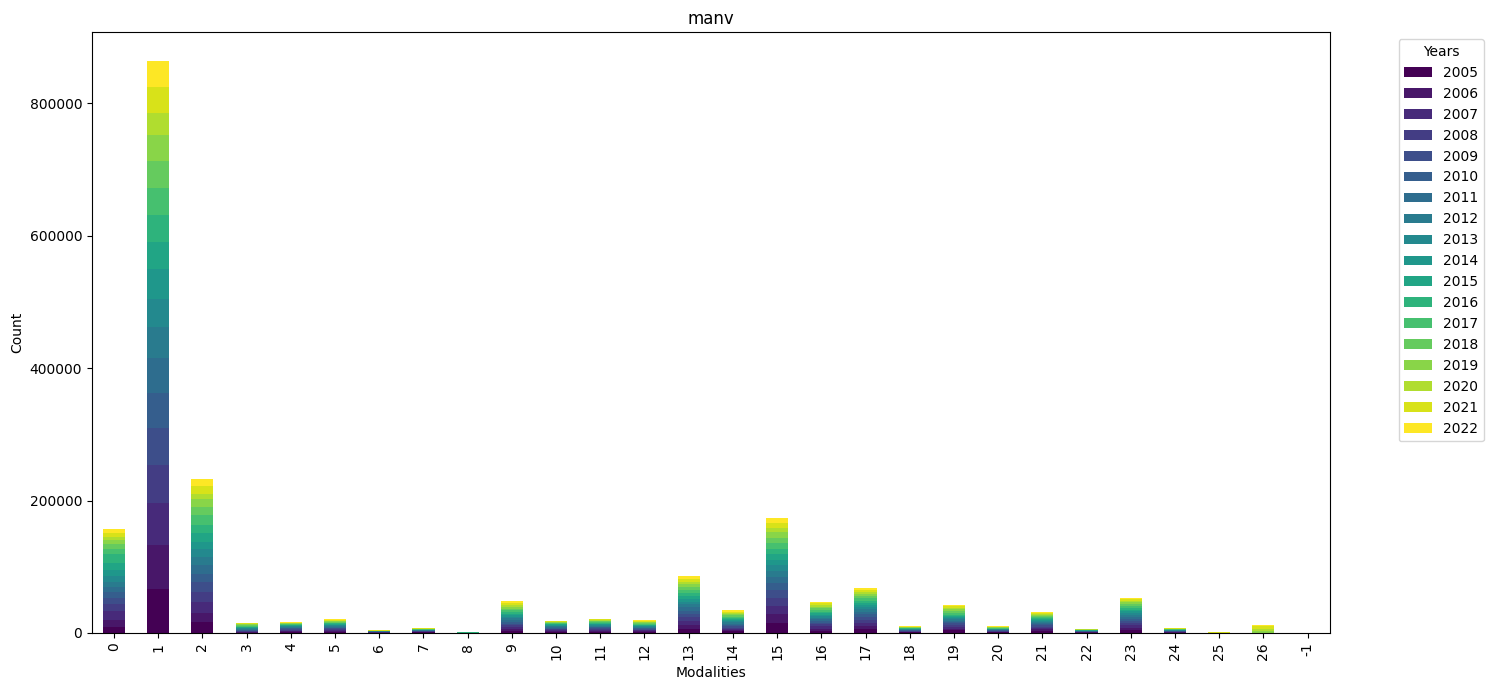

2024-06-10 16:34:16,164 - WARNING - Le nombre de modalités uniques dans la colonne manv excède le seuil de 12. Aucun graphique en ligne généré.
2024-06-10 16:34:16,416 - INFO - La colonne num_veh n'est pas numérique.
2024-06-10 16:34:16,499 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Auncun bar plot généré.
2024-06-10 16:34:16,579 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: num_veh / lignes: 2009395
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A01                                         0                                    0
   2006  object  A01                                         0                                    0
   2007  object  A01                                         0                                    0
   2008  object  A01                                         0                                    0
   2009  object  A01                                         0                                    0
   2010  object  A01                                         0                                    0
   2011  object  A01                                         0                                    0
   2012  object  A01                                         0  

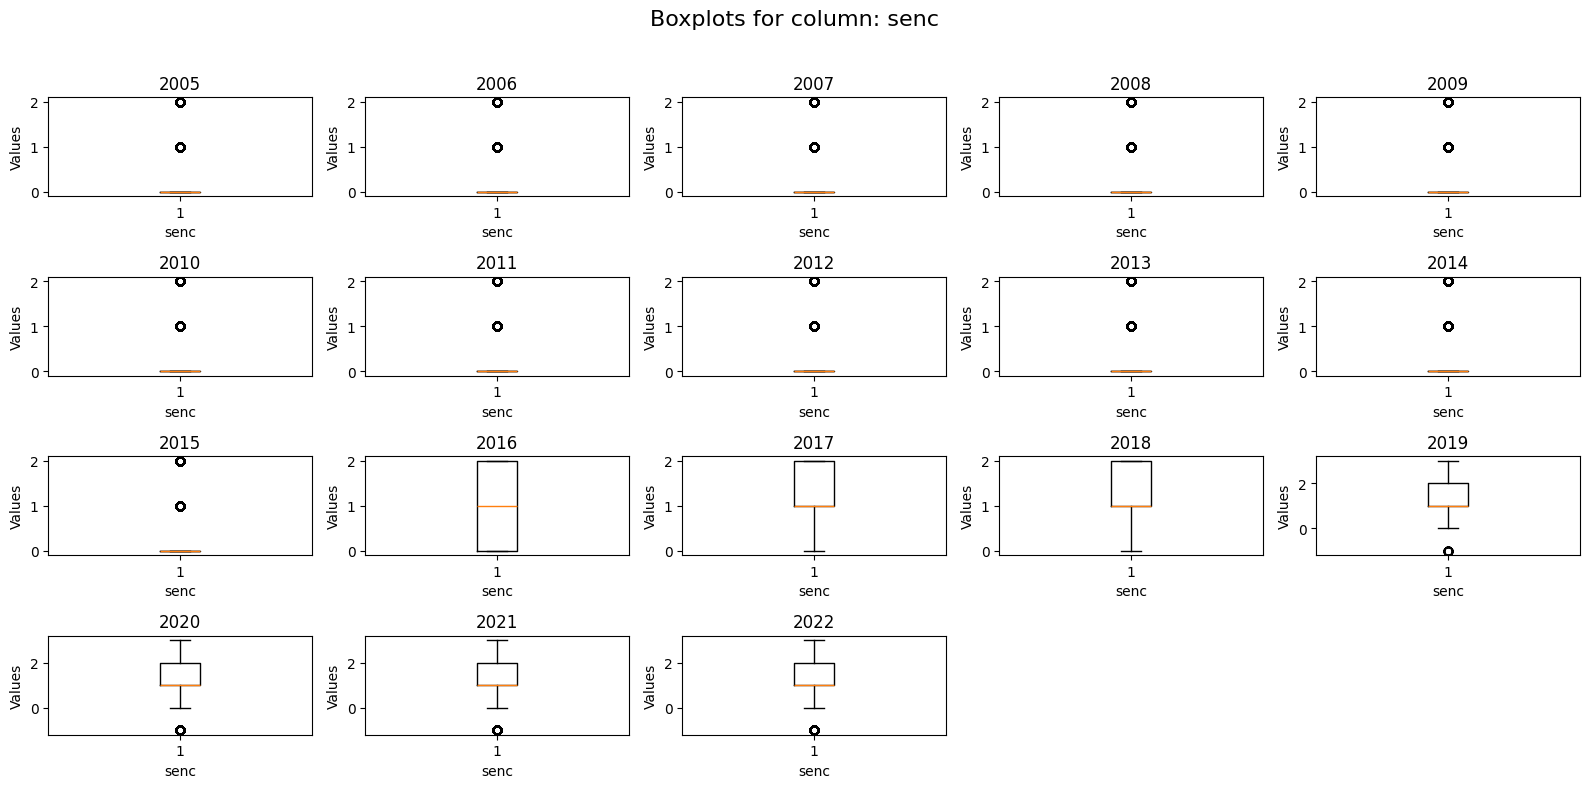

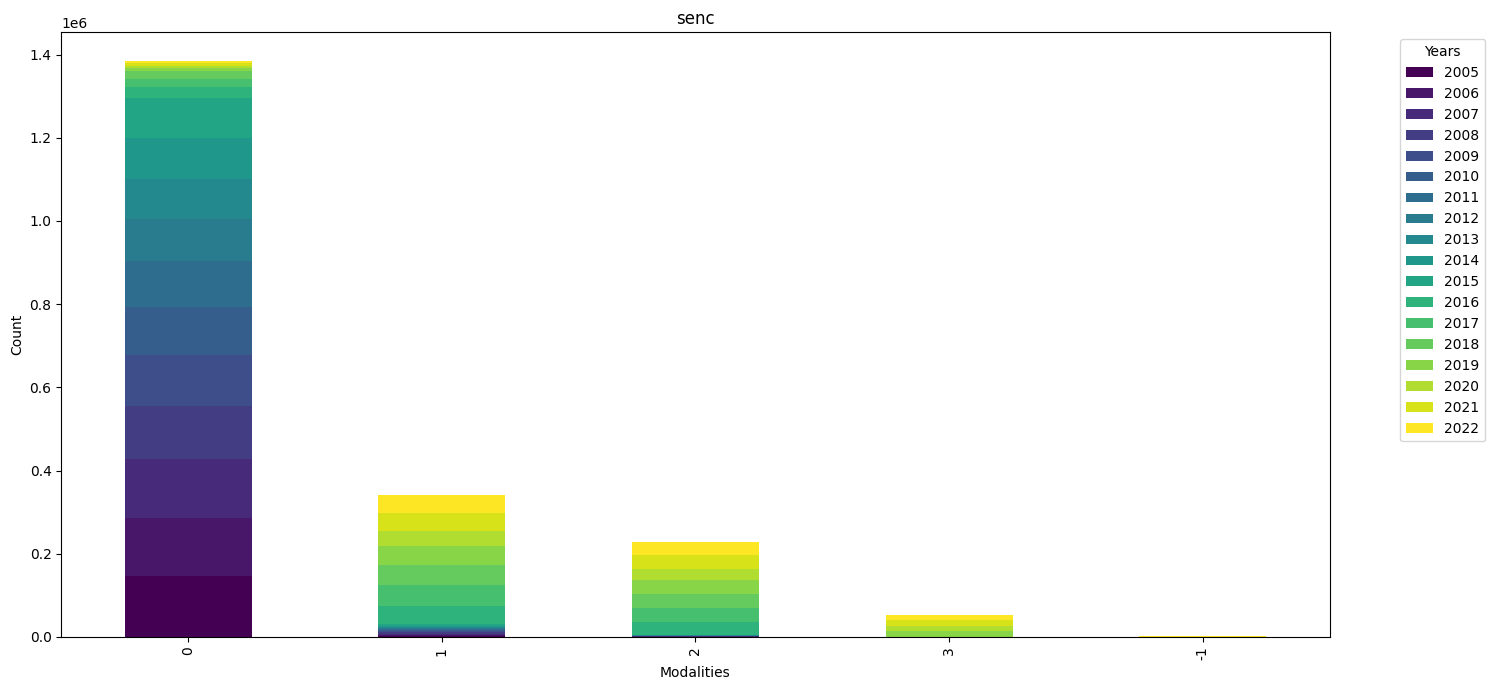

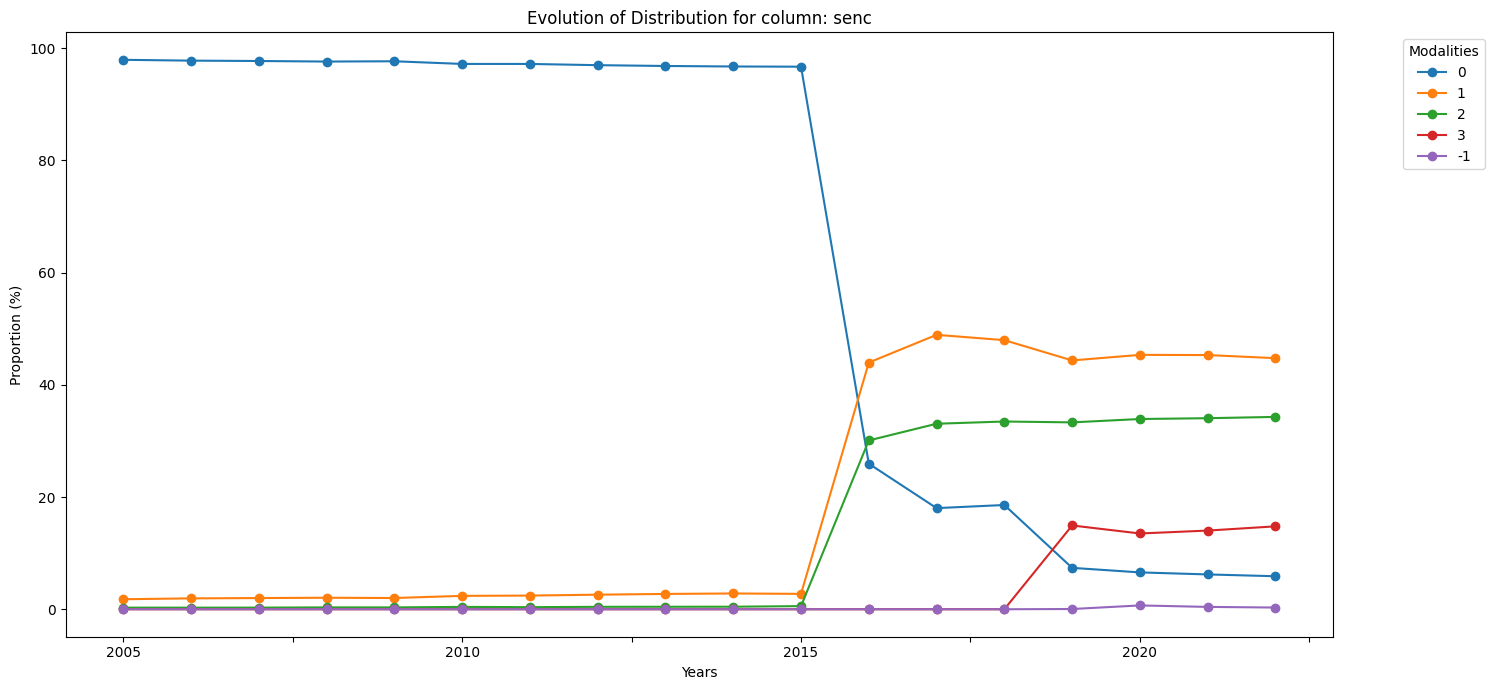


Colonne: Num_Acc / lignes: 2009395
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012  int64   2.012e+11           

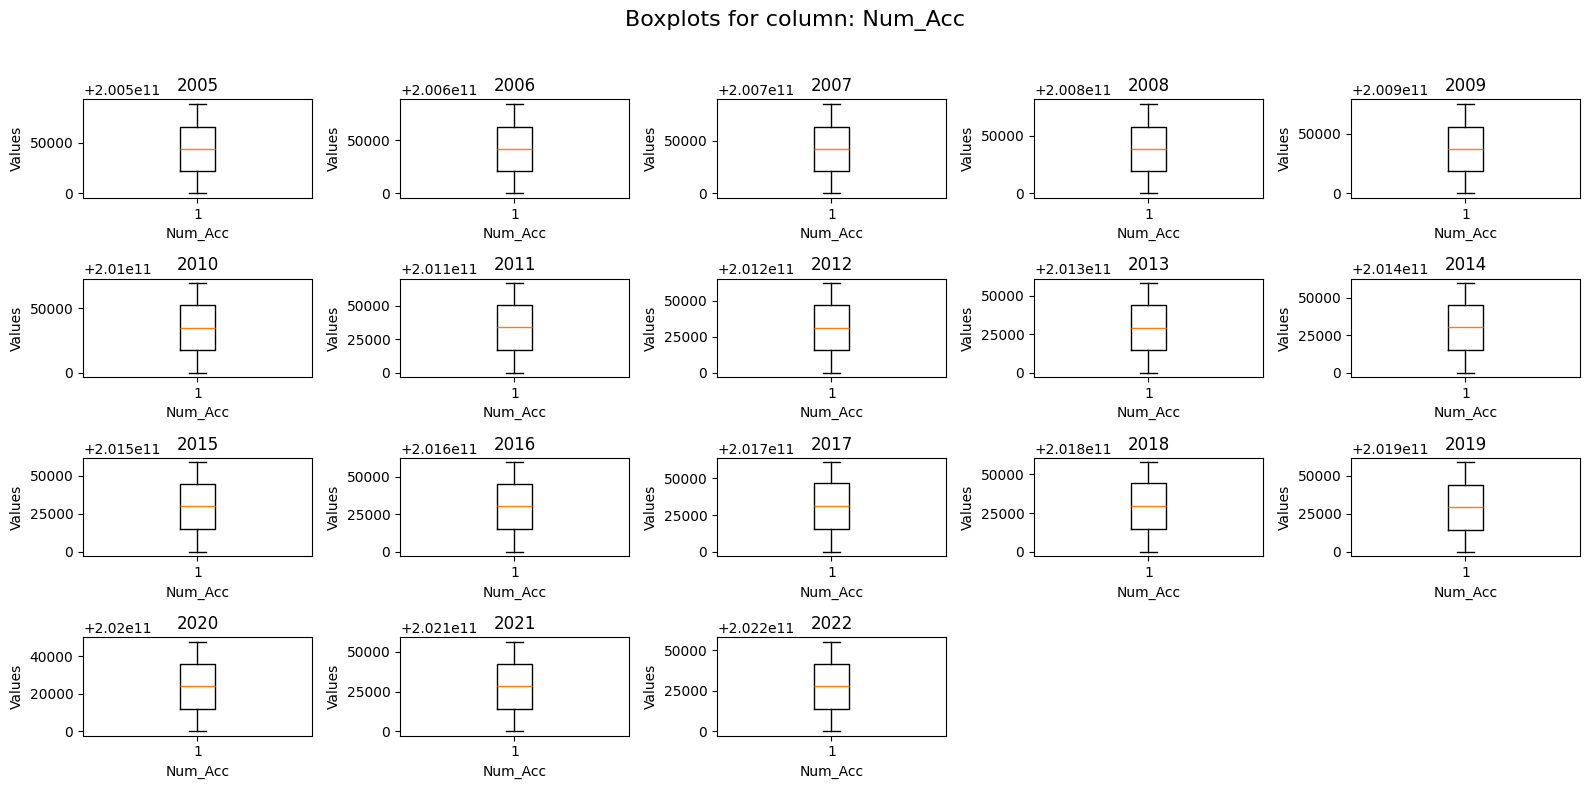

2024-06-10 16:34:21,413 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 16:34:21,680 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: motor / lignes: 2009395
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        1                                      0                                    0
   2020  int64        1                                      0                                    0
   2021  int64        1                                      0                                    0
   2022  int64        1                                      0                                    0


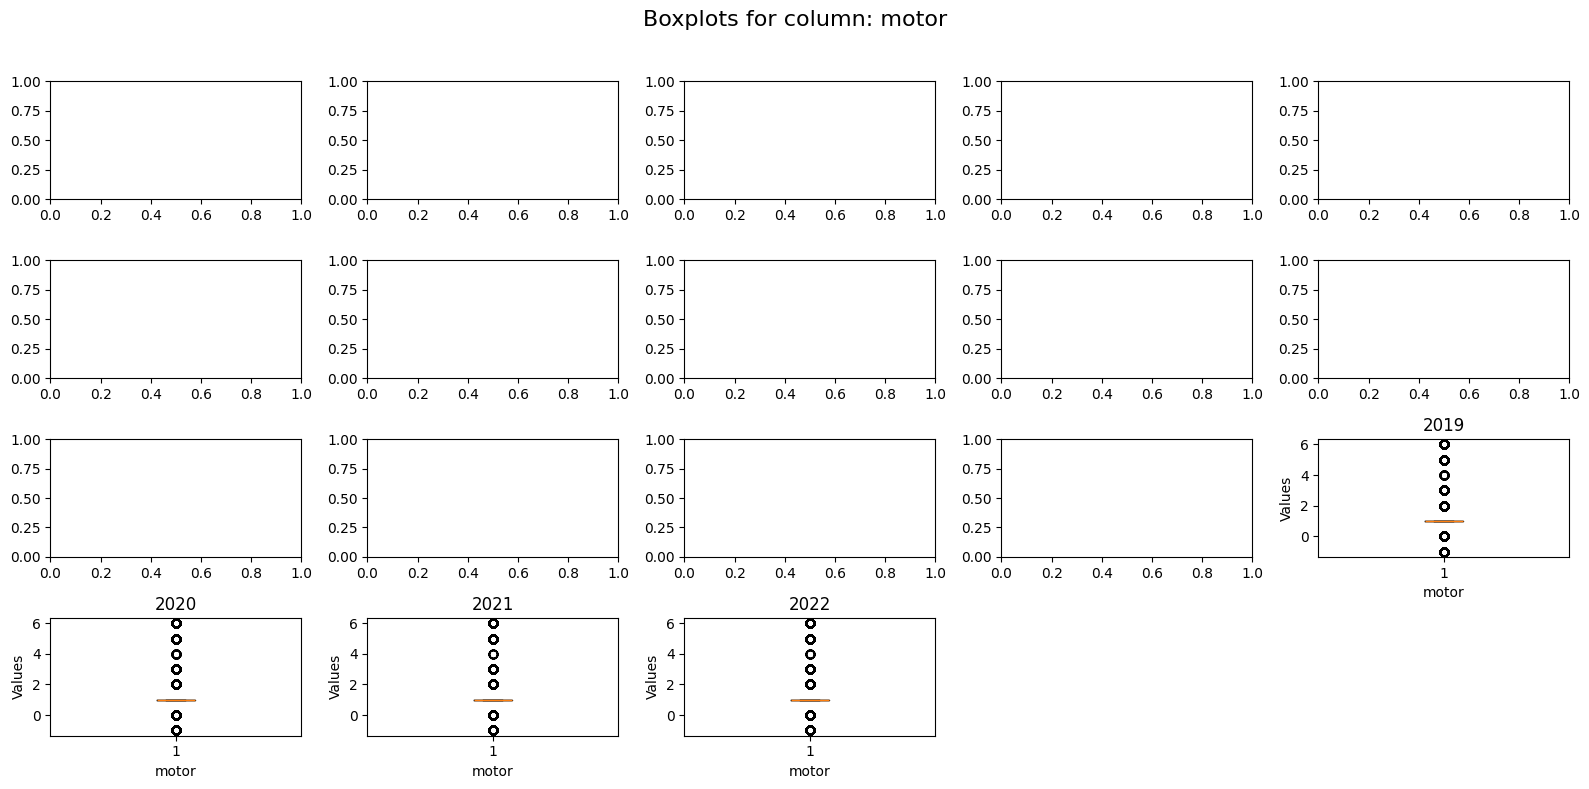

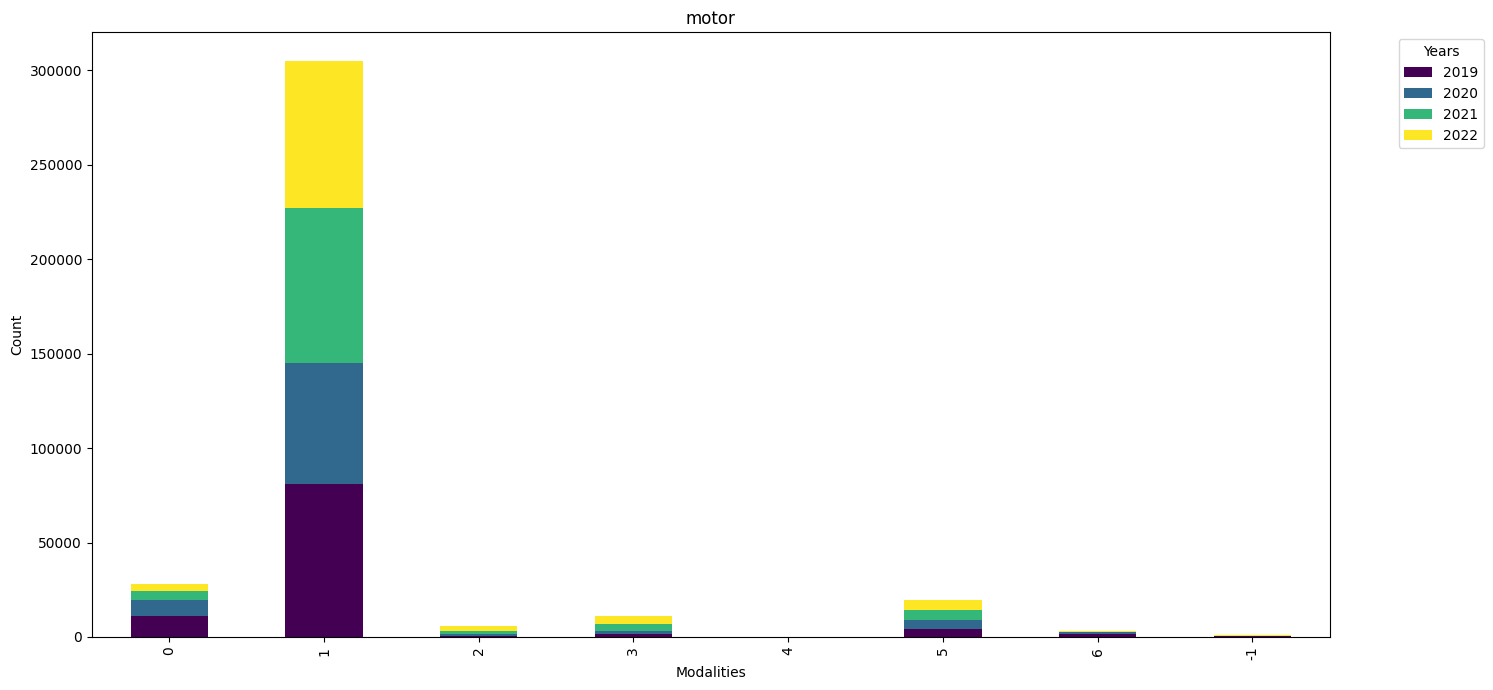

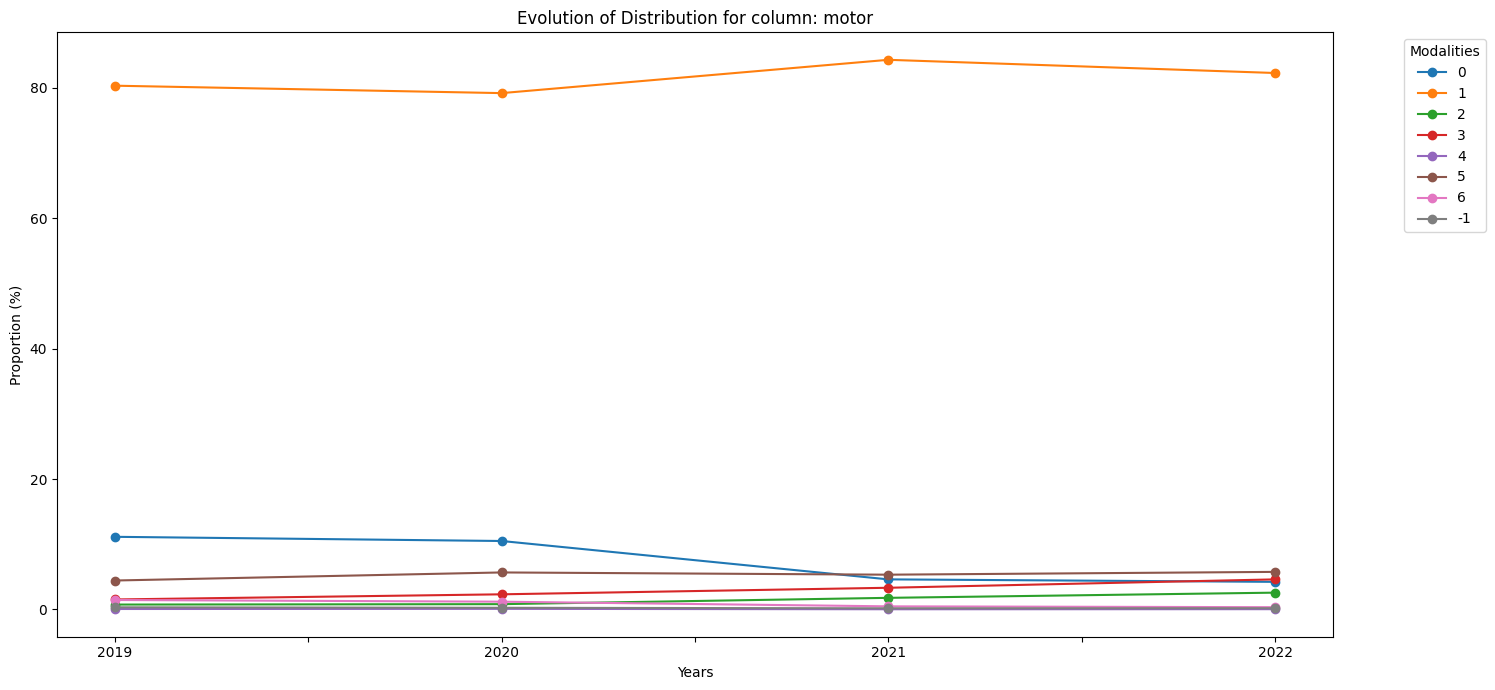


Colonne: catv / lignes: 2009395
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        7                                      0                                    0
   2006  int64        7                                      0                                    0
   2007  int64        7                                      0                                    0
   2008  int64        7                                      0                                    0
   2009  int64        7                                      0                                    0
   2010  int64        7                                      0                                    0
   2011  int64        7                                      0                                    0
   2012  int64        7                                      0     

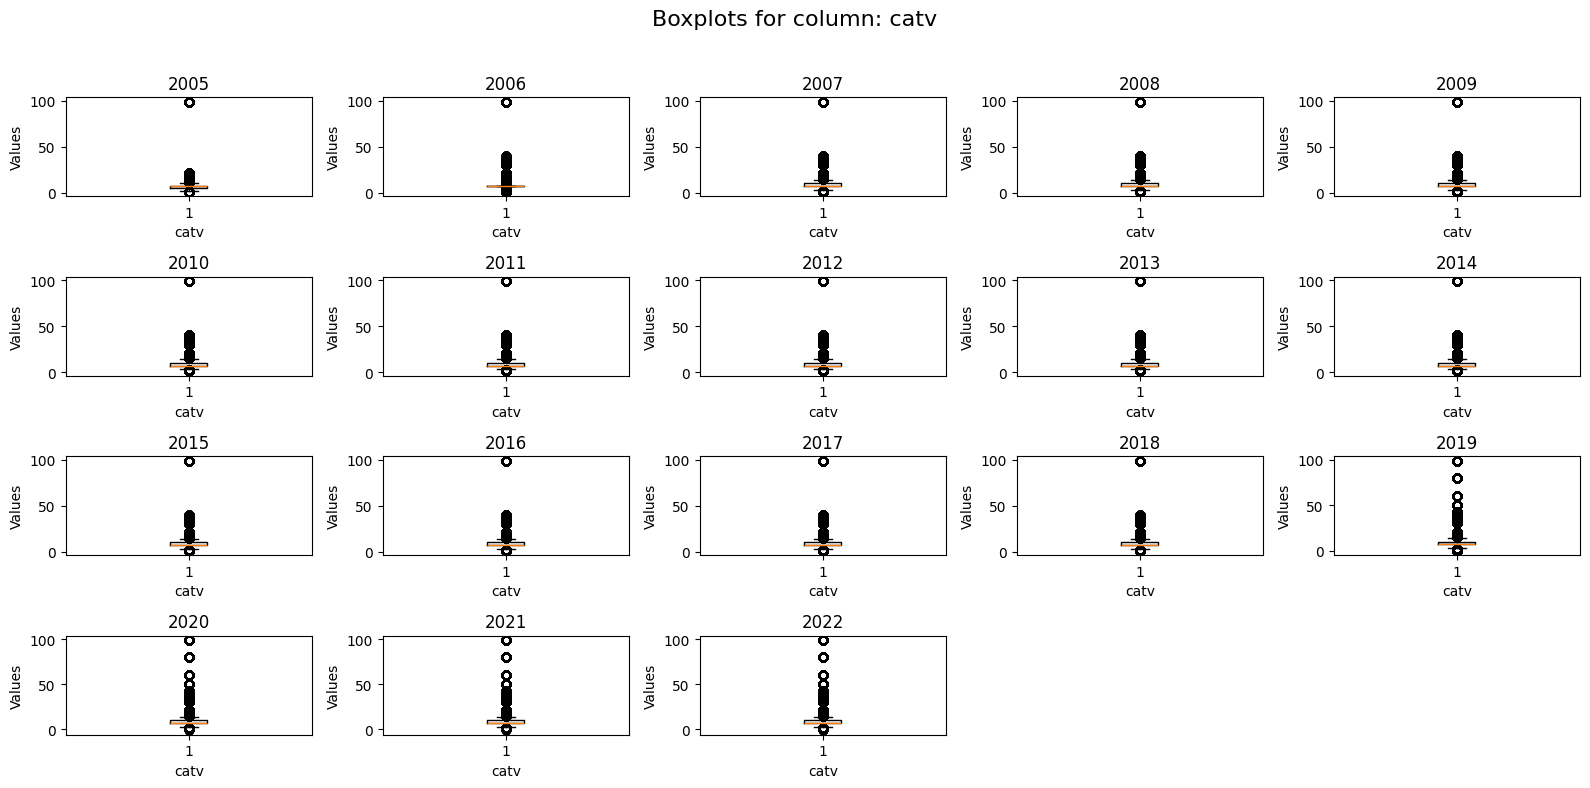

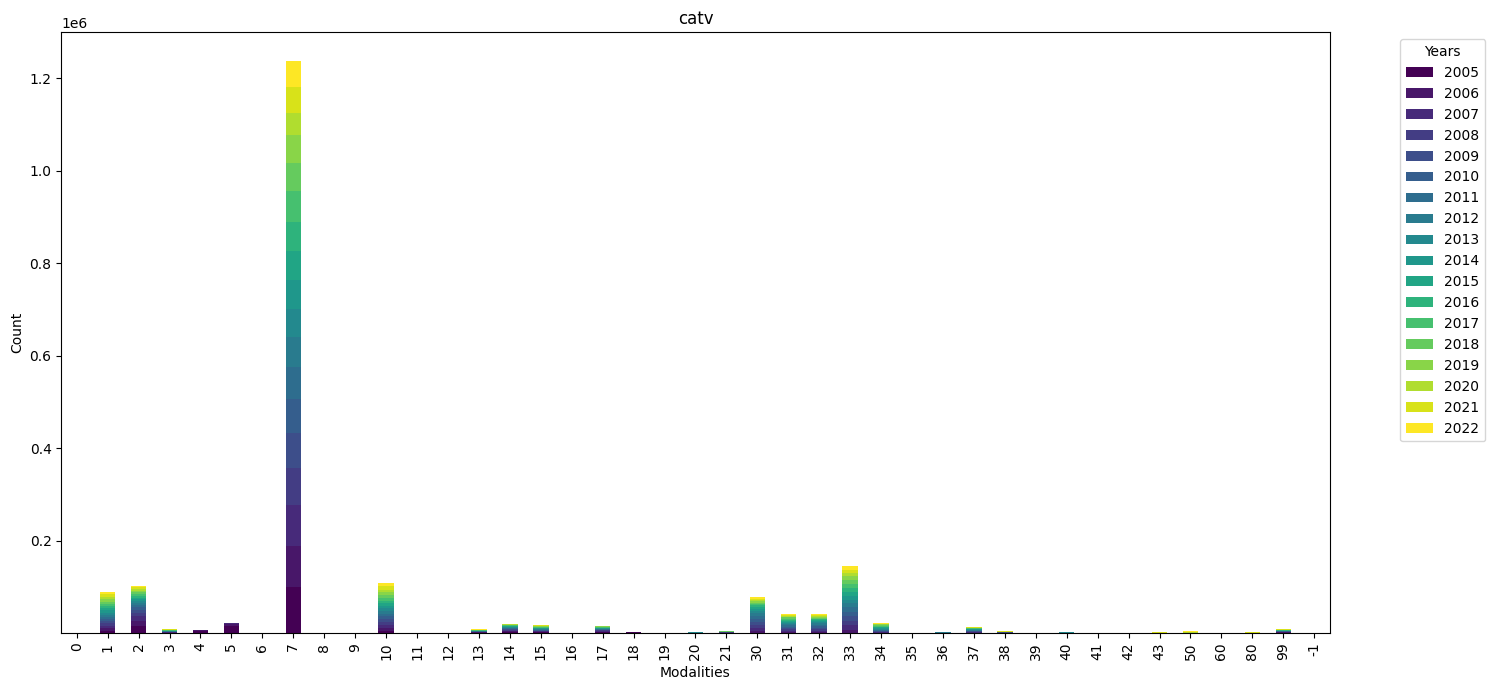

2024-06-10 16:34:27,373 - WARNING - Le nombre de modalités uniques dans la colonne catv excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: occutc / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                                 0                                 0
   2006  int64         0                                 0                                 0
   2007  int64         0                                 0                                 0
   2008  int64         0                                 0                                 0
   2009  int64         0                                 0                                 0
   2010  int64         0                                 0                                 0
   2011  int64         0                                 0                                 0
   2012  int64         0                                 0                                 0
   2013  int64     

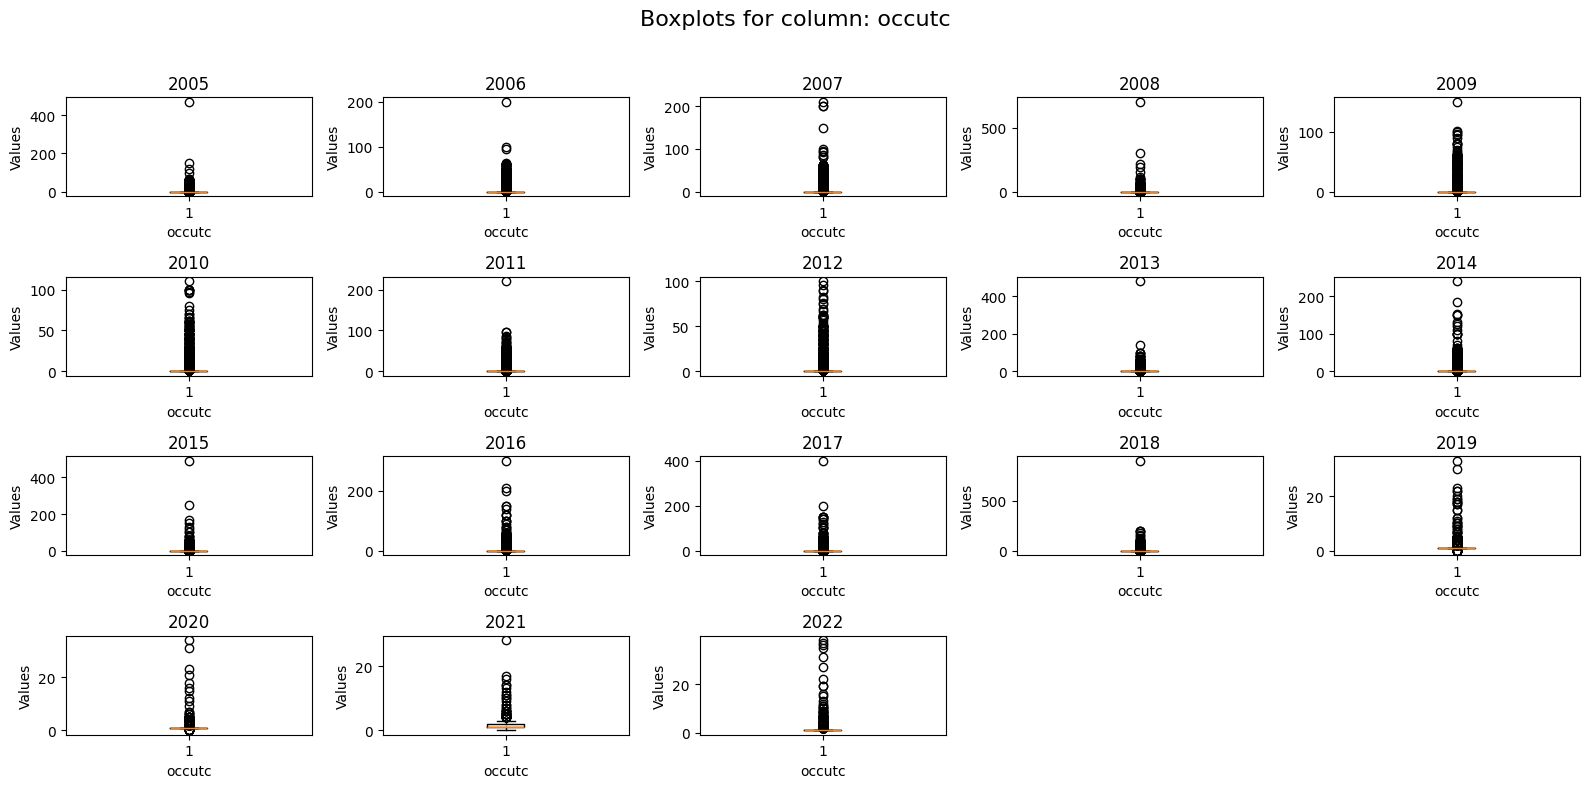

2024-06-10 16:34:29,220 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 16:34:29,350 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 12. Aucun graphique en ligne généré.


In [227]:
for datasets in dataframes:
        analyze_all_columns(datasets)